In [1]:
!pip install nbformat IPython
!pip install numpy
!pip install ipython


In [2]:
import nbformat
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def run_notebook(notebook_path):
    # Read the notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        nb = read(f, as_version=4)

    # Create an instance of the InteractiveShell
    shell = InteractiveShell.instance()

    # Execute each cell
    for cell in nb.cells:
        if cell.cell_type == 'code':
            shell.run_cell(cell.source)




In [3]:
import pandas as pd

all_mf_data_path              = './Data/MF_Data/Results/End_product/20240511_updated_eq_mf_data_v2.xlsx'
mf_meta_data                  = pd.read_excel(all_mf_data_path, sheet_name= "MF Meta")
all_funds                     = mf_meta_data['Fund Id'].tolist()

In [4]:
import random
import numpy as np

def select_funds_and_allocate_weights(fund_ids, n=20):
    selected_funds = random.sample(fund_ids, n)

    # Generate random weights
    weights = np.random.rand(n)
    weights /= weights.sum()  # Normalize to sum to 1

    return selected_funds, weights


In [20]:
# Create a DataFrame
user_selection_exp = pd.DataFrame({
    'EXPERIMENT_NO': [],
    'FUND_SELECTED': [],
    'AMOUNT': []
})

experiment_results = pd.DataFrame({
    'EXPERIMENT_NO': [],
    'OVERLAP': [],
    'ALPHA': [],
    'HHI' : []
})


In [ ]:

run_notebook('Prepare_index_fund_data.ipynb')


for exp_no in range(50):
    print("Running exp no ", exp_no)
    selected_funds, weights = select_funds_and_allocate_weights(all_funds)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'EXPERIMENT_NO': exp_no,
        'FUND_SELECTED': selected_funds,
        'AMOUNT': weights*100000
    })

    user_selection_exp  = pd.concat([user_selection_exp, df], ignore_index=True)
    df                  = df.drop(df.columns[0], axis=1)

    # Save to CSV
    df.to_csv('./Data/user_selection_v2.csv', index=False)

    run_notebook('melt_portfolio.ipynb')
    run_notebook('EROptimizerV2.ipynb')

    exp_df = pd.DataFrame({
        'EXPERIMENT_NO': [exp_no],
        'OVERLAP': [round(new_overlap*100,2)],
        'ALPHA': [round((new_er - user_er)*100,2)],
        'HHI' : [round(new_hhi)]
    })

    experiment_results = pd.concat([experiment_results, exp_df], ignore_index=True)



In [28]:
#Sample output 

print("This is how sample output looks for any user : \n\n")

# Convert proportions to percentages, filter out zero values, and add % sign
inv_proportion = {k: f"{round(v * 100, 2)}%" for k, v in saved_proportions.items() if v != 0}

# Print the final proportions
print("Guys here is what we propose \n\n", inv_proportion)

new_overlap      = calc_overlap(index_df, user_df, saved_proportions)      
new_er           = calc_expected_return(fund_er, saved_proportions)
new_hhi          = get_sector_hhi(saved_proportions,index_df_sec)



print("\n\nWe bring in alpha of :", round((new_er - user_er)*100,2), "%")
print("Overlap with your existing portfolio would still be", round(new_overlap*100,2), "%")
print("And your sectoral HHI had to move from", round(target_hhi), "to",round(new_hhi))


This is how sample output looks for any user : 


Guys here is what we propose 

 {'ID11': '0.22%', 'ID12': '0.99%', 'ID15': '32.41%', 'ID18': '1.58%', 'ID20': '6.88%', 'ID24': '16.59%', 'ID26': '3.99%', 'ID27': '1.99%', 'ID30': '4.76%', 'ID34': '3.36%', 'ID36': '5.36%', 'ID4': '16.37%', 'ID6': '4.84%', 'ID9': '0.67%'}


We bring in alpha of : 2.44 %
Overlap with your existing portfolio would still be 61.18 %
And your sectoral HHI had to move from 343 to 322


In [23]:
excel_output             = 'Experiment_results.xlsx'
with pd.ExcelWriter(excel_output, engine='openpyxl') as writer:
    user_selection_exp.to_excel(writer, sheet_name='Selected Funds', index=False)
    experiment_results.to_excel(writer, sheet_name='Experiment Results', index=False)


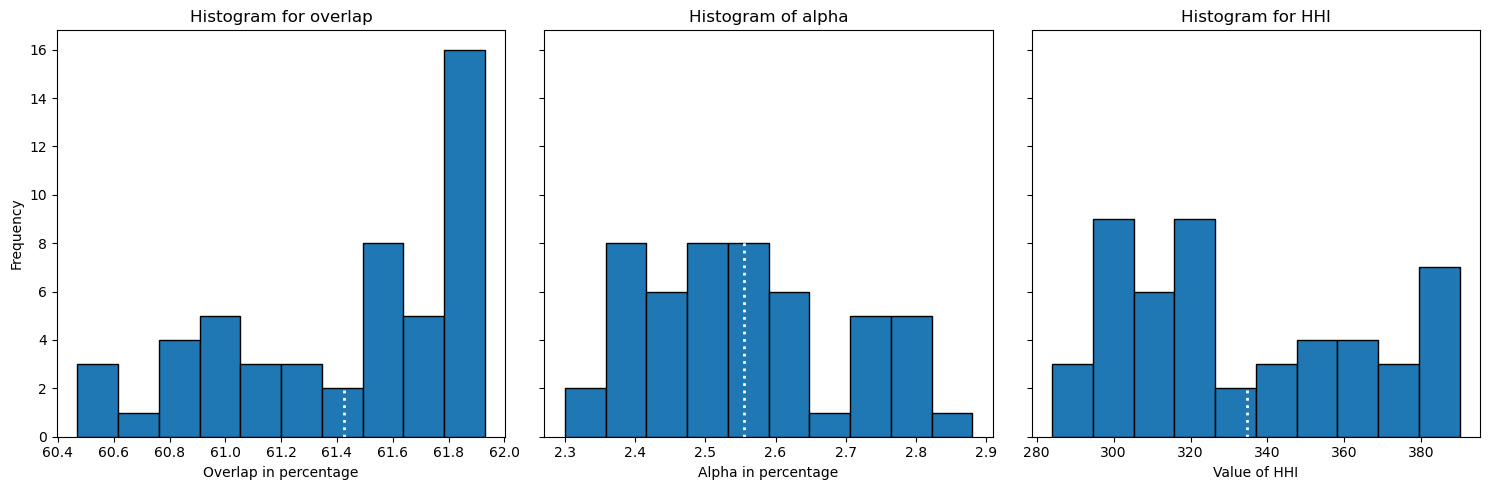

In [25]:
import matplotlib.pyplot as plt

# Sample data for the histograms
data1 =  experiment_results['OVERLAP'].tolist()
data2 =  experiment_results['ALPHA'].tolist()
data3 =  experiment_results['HHI'].tolist()

# Calculate means
mean1 = np.mean(data1)
mean2 = np.mean(data2)
mean3 = np.mean(data3)


# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot histograms
axs[0].hist(data1, bins=10, edgecolor='black')
axs[0].axvline(mean1, color='w', linestyle='dotted', linewidth=2)
axs[0].set_title('Histogram for overlap')
axs[0].set_xlabel('Overlap in percentage')
axs[0].set_ylabel('Frequency')

axs[1].hist(data2, bins=10, edgecolor='black')
axs[1].axvline(mean2, color='w', linestyle='dotted', linewidth=2)
axs[1].set_title('Histogram of alpha')
axs[1].set_xlabel('Alpha in percentage')

axs[2].hist(data3, bins=10, edgecolor='black')
axs[2].axvline(mean3, color='w', linestyle='dotted', linewidth=2)
axs[2].set_title('Histogram for HHI')
axs[2].set_xlabel('Value of HHI')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
